<a href="https://colab.research.google.com/github/Haarini/Movie-Review-Sentiment-Analysis/blob/master/Sentiment_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# An Analysis of sentiments in a movie review dataset using different neural network algorithms

Importing the necessary libraries 

In [0]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

Importing the glue (The Stanford Sentiment Treebank) dataset that consists of sentences from movie reviews and human annotations of their sentiments

In [2]:
dataset,info=tfds.load('glue/sst2',with_info=True)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/glue/sst2/1.0.0.incompleteP901J3/glue-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/glue/sst2/1.0.0.incompleteP901J3/glue-validation.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/glue/sst2/1.0.0.incompleteP901J3/glue-test.tfrecord


Dataset glue downloaded and prepared to /root/tensorflow_datasets/glue/sst2/1.0.0. Subsequent calls will reuse this data.


Printing the features of the dataset. 

There are two classes of sentiments namely negative and positive among which these reviews are going to be scaled and classified

In [3]:
print(info.features)
print(info.features["label"].num_classes)
print(info.features["label"].names)

FeaturesDict({
    'idx': tf.int32,
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    'sentence': Text(shape=(), dtype=tf.string),
})
2
['negative', 'positive']


Dividing the imported dataset into training and validation datasets

In [0]:
dataset_train,dataset_validation=dataset['train'],dataset['validation']

In [5]:
dataset_train
dataset_validation

<DatasetV1Adapter shapes: {idx: (), label: (), sentence: ()}, types: {idx: tf.int32, label: tf.int64, sentence: tf.string}>

In [6]:
for sample in dataset_train.take(2):
  review,label=sample["sentence"],sample["label"]
  print("Review:",review)
  print("Label : %d \n" %label.numpy())

Review: tf.Tensor(b'for the uninitiated plays better on video with the sound ', shape=(), dtype=string)
Label : 0 

Review: tf.Tensor(b'like a giant commercial for universal studios , where much of the action takes place ', shape=(), dtype=string)
Label : 0 



The dataset will label 1 for a positive review and 0 for a negative review

In [9]:
training_reviews=[]
training_labels=[]
validation_reviews=[]
validation_labels=[]

for item in dataset_train.take(10000):
  review,label=item["sentence"],item["label"]
  training_reviews.append(str(review.numpy()))
  training_labels.append(label.numpy())

print("\n Number of training reviews is:" , len(training_reviews))

print("Training reviews and lables")
for i in range(0,5):
  print(training_reviews[i])
  print(training_labels[i])

for item in dataset_validation.take(-1):
  review,label=item['sentence'],item["label"]
  validation_reviews.append(str(review.numpy()))
  validation_labels.append(label.numpy())

print ("\nNumber of validation reviews is: ", len(validation_reviews))

print("Validation reviews and labels")
for i in range(0, 5):
  print (validation_reviews[i])
  print (validation_labels[i])


 Number of training reviews is: 10000
Training reviews and lables
b'for the uninitiated plays better on video with the sound '
0
b'like a giant commercial for universal studios , where much of the action takes place '
0
b'company once again dazzle and delight us '
1
b"'s no surprise that as a director washington demands and receives excellent performances , from himself and from newcomer derek luke "
1
b', this cross-cultural soap opera is painfully formulaic and stilted . '
0

Number of validation reviews is:  872
Validation reviews and labels
b'a valueless kiddie paean to pro basketball underwritten by the nba . '
0
b"featuring a dangerously seductive performance from the great daniel auteuil , `` sade '' covers the same period as kaufmann 's `` quills '' with more unsettlingly realistic results . "
1
b'i am sorry that i was unable to get the full brunt of the comedy . '
0
b'the inspirational screenplay by mike rich covers a lot of ground , perhaps too much , but ties things togethe

Defining the basic text preprocessing data required and tokenizing the data

In [0]:
vocab_size = 4000
embedding_dim = 16
max_length = 50
trunc_type='post'
pad_type='post'
oov_tok = "<OOV>"

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_reviews)
word_index = tokenizer.word_index


Padding the input sequence after tokenizing the input data

In [0]:
# Pad the sequences so that they are all the same length
training_sequences = tokenizer.texts_to_sequences(training_reviews)
training_padded = pad_sequences(training_sequences,maxlen=max_length, 
                                truncating=trunc_type, padding=pad_type)

validation_sequences = tokenizer.texts_to_sequences(validation_reviews)
validation_padded = pad_sequences(validation_sequences,maxlen=max_length)

training_labels_final = np.array(training_labels)
validation_labels_final = np.array(validation_labels)

Defining a neural network using tensorflow to process the tokenized and padded text embeddings

In [12]:
model=tf.keras.Sequential([
                           tf.keras.layers.Embedding(vocab_size,embedding_dim,input_length=max_length),
                           tf.keras.layers.GlobalAveragePooling1D(),
                           tf.keras.layers.Dense(1,activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            64000     
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 64,017
Trainable params: 64,017
Non-trainable params: 0
_________________________________________________________________


In [13]:
num_epochs=25
history=model.fit(training_padded,training_labels_final,epochs=num_epochs,validation_data=
                  (validation_padded,validation_labels_final))

Epoch 1/25
313/313 [==============================] - 1s 3ms/step - loss: 0.6835 - accuracy: 0.5583 - val_loss: 0.6864 - val_accuracy: 0.5344
Epoch 2/25
313/313 [==============================] - 1s 2ms/step - loss: 0.6715 - accuracy: 0.5766 - val_loss: 0.6713 - val_accuracy: 0.6009
Epoch 3/25
313/313 [==============================] - 1s 2ms/step - loss: 0.6508 - accuracy: 0.6249 - val_loss: 0.6448 - val_accuracy: 0.6571
Epoch 4/25
313/313 [==============================] - 1s 2ms/step - loss: 0.6220 - accuracy: 0.6728 - val_loss: 0.6152 - val_accuracy: 0.6904
Epoch 5/25
313/313 [==============================] - 1s 2ms/step - loss: 0.5890 - accuracy: 0.7132 - val_loss: 0.5840 - val_accuracy: 0.7041
Epoch 6/25
313/313 [==============================] - 1s 2ms/step - loss: 0.5551 - accuracy: 0.7436 - val_loss: 0.5556 - val_accuracy: 0.7122
Epoch 7/25
313/313 [==============================] - 1s 2ms/step - loss: 0.5240 - accuracy: 0.7668 - val_loss: 0.5321 - val_accuracy: 0.7466
Epoch 

This embedding model gave a training accuracy of 88% and vlidation accuracy of 75% which are plotted in the graph

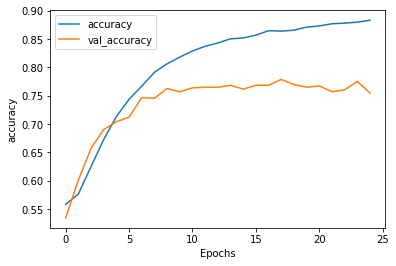

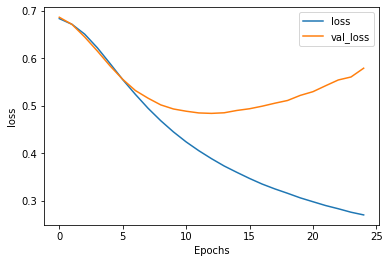

In [17]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")


Inputting some random reviews to check for the model's sentiment prediction.
The prediction scale ranges between 0(negative) to 1(positive)

In [18]:
review_1 = """The moview was really good"""
review_2 = """It was a very horrible movie"""
review_3 = """The story behind the moview was good but the way it was shot was not upto the mark"""
new_reviews=[review_1,review_2,review_3]
print(new_reviews)

['The moview was really good', 'It was a very horrible movie', 'The story behind the moview was good but the way it was shot was not upto the mark']


In [25]:
def predictreview(model, reviews):

  padding_type='post'
  sample_sequences = tokenizer.texts_to_sequences(reviews)
  reviews_padded = pad_sequences(sample_sequences,padding=padding_type,maxlen=max_length)
  classes = model.predict(reviews_padded)
  for x in range(len(reviews_padded)):
    print(reviews[x])
    print(classes[x])
    print('\n')

predictreview(model,new_reviews)



The moview was really good
[0.7615478]


It was a very horrible movie
[0.26081142]


The story behind the moview was good but the way it was shot was not upto the mark
[0.9735791]




#Comparison of CNN, GRU , Single Bideirectional LSTM , Multiple Bidirectional LSTM for the movie review sentiment analysis

In [0]:
def show_results(model, reviews):
  model.summary()
  history=model.fit(training_padded,training_labels_final,epochs=num_epochs,validation_data=(validation_padded,validation_labels_final))
  plot_graphs(history, "accuracy")
  plot_graphs(history, "loss")
  predictreview(model, reviews)

A CNN model for review analysis

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 16)            64000     
_________________________________________________________________
conv1d (Conv1D)              (None, 46, 16)            1296      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 65,313
Trainable params: 65,313
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
313/313 [==============================] - 1s 4ms/step - loss: 0.6910 - accuracy: 0.5360 - val_loss: 0.6922 - val_accuracy: 0.5264
Epoch 2/50
313/313 [==============================] - 1s 4ms/step - loss: 0.6837 - accuracy: 0.5592 - val_

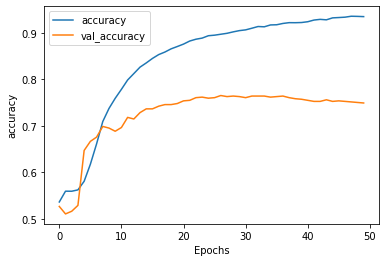

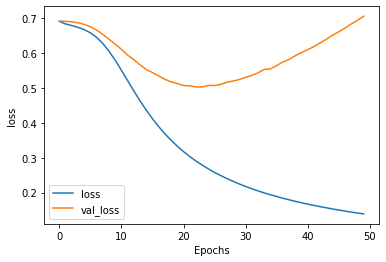

The moview was really good
[0.93312967]


It was a very horrible movie
[0.19715147]


The story behind the moview was good but the way it was shot was not upto the mark
[0.97720784]




In [27]:
num_epochs=50
cnn_model=tf.keras.Sequential([
                               tf.keras.layers.Embedding(vocab_size,embedding_dim,input_length=max_length),
                               tf.keras.layers.Conv1D(16,5,activation='relu'),
                               tf.keras.layers.GlobalMaxPool1D(),
                               tf.keras.layers.Dense(1,activation='sigmoid')
])
learning_rate = 0.0001
cnn_model.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate), 
                  metrics=['accuracy'])
show_results(cnn_model, new_reviews)

A GRU model for moview review sentiment analysis

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 16)            64000     
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                9600      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 73,665
Trainable params: 73,665
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
313/313 [==============================] - 13s 42ms/step - loss: 0.6879 - accuracy: 0.5542 - val_loss: 0.6966 - val_accuracy: 0.5092
Epoch 2/50
313/313 [==============================] - 12s 40ms/step - loss: 0.6811 - accuracy: 0.5590 - val_loss: 0.7057 - val_accuracy: 0.5092
Epoch 3/50
313/313 [==============================] - 12s 39ms/step - loss: 0.6593 - accurac

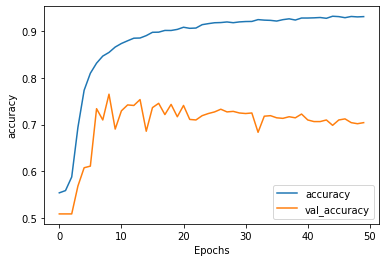

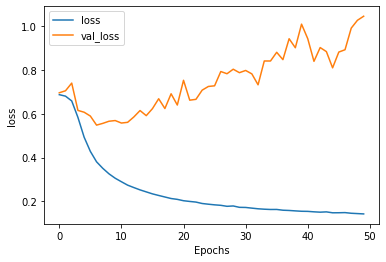

The moview was really good
[0.9631186]


It was a very horrible movie
[0.03723393]


The story behind the moview was good but the way it was shot was not upto the mark
[0.99999404]




In [28]:
num_epochs=50
gru_model = tf.keras.Sequential([
                                 tf.keras.layers.Embedding(vocab_size,embedding_dim,input_length=max_length),
                                 tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
                                 tf.keras.layers.Dense(1,activation='sigmoid')
])

learning_rate=0.0001
gru_model.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate),
                  metrics=['accuracy'])
show_results(gru_model, new_reviews)

A bidirectional LSTM for movie review sentiment analysis

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 16)            64000     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 32)                4224      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 68,257
Trainable params: 68,257
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
313/313 [==============================] - 10s 33ms/step - loss: 0.6878 - accuracy: 0.5590 - val_loss: 0.6946 - val_accuracy: 0.5092
Epoch 2/50
313/313 [==============================] - 10s 31ms/step - loss: 0.6824 - accuracy: 0.5590 - val_loss: 0.7013 - val_accuracy: 0.5092
Epoch 3/50
313/313 [==============================] - 9s 30ms/step - loss: 0.6735 - accuracy

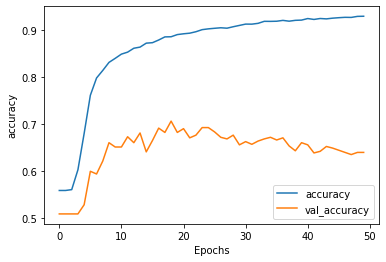

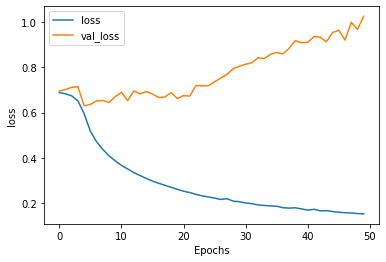

The moview was really good
[0.951442]


It was a very horrible movie
[0.01589546]


The story behind the moview was good but the way it was shot was not upto the mark
[0.99725276]




In [29]:
num_epochs=50
bidi_lstm_model=tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)), 
    tf.keras.layers.Dense(1, activation='sigmoid')
])

learning_rate = 0.0001
bidi_lstm_model.compile(loss='binary_crossentropy',
                        optimizer=tf.keras.optimizers.Adam(learning_rate),
                        metrics=['accuracy'])
show_results(bidi_lstm_model, new_reviews)

A Bidirectional LSTM Model for the same analysis

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 50, 16)            64000     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 50, 32)            4224      
_________________________________________________________________
bidirectional_3 (Bidirection (None, 32)                6272      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 74,529
Trainable params: 74,529
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
313/313 [==============================] - 20s 63ms/step - loss: 0.6882 - accuracy: 0.5533 - val_loss: 0.6965 - val_accuracy: 0.5092
Epoch 2/50
313/313 [==============================] - 18s 58ms/step - loss: 0.6831 - accuracy: 0.5590 - 

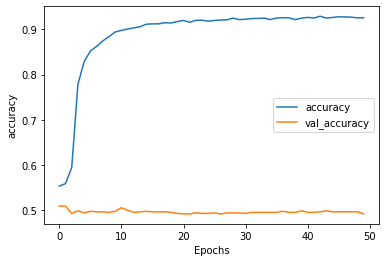

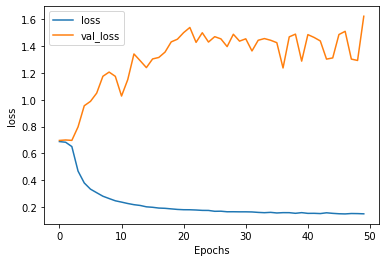

The moview was really good
[0.98660916]


It was a very horrible movie
[0.02429139]


The story behind the moview was good but the way it was shot was not upto the mark
[0.99525094]




In [30]:
num_epochs = 50

multiple_bidi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, 
                                                       return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

learning_rate = 0.0001
multiple_bidi_lstm_model.compile(loss='binary_crossentropy',
                                 optimizer=tf.keras.optimizers.Adam(learning_rate),
                                 metrics=['accuracy'])
show_results(multiple_bidi_lstm_model, new_reviews)

In [0]:
review1 = """I loved this movie"""

review2 = """that was the worst movie I've ever seen"""

review3 = """too much violence even for a Bond film"""

review4 = """a captivating recounting of a cherished myth"""

review5 = """I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can\'t go wrong with a movie with Whoopi Goldberg in it."""

review6 = """I don\'t understand why it received an oscar recommendation
 for best movie, it was long and boring"""

review7 = """the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!"""

review8 = """The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it again"""

review9 = """I had expected so much more from a movie made by the director 
 who made my most favorite movie ever, I was very disappointed in the tedious 
 story"""

review10 = "I wish I could watch this movie every day for the rest of my life"

more_reviews = [review1, review2, review3, review4, review5, review6, review7, 
               review8, review9, review10]

In [32]:
print("============================\n","Embeddings only:\n", "============================")
predict_review(model, more_reviews)

 Embeddings only:
I loved this movie
[0.44860104]


that was the worst movie I've ever seen
[0.10198039]


too much violence even for a Bond film
[0.01316333]


a captivating recounting of a cherished myth
[0.70612293]


I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can't go wrong with a movie with Whoopi Goldberg in it.
[0.33704603]


I don't understand why it received an oscar recommendation
 for best movie, it was long and boring
[0.6171988]


the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!
[0.39073133]


The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it again
[0.5548585]


I had expected so much more from a movie made by the director 
 who made my most favorite movie ever, I was very disappointed in the tedious 
 story
[0.0044741]


I wish I cou

In [34]:
print("============================\n","With CNN\n", "============================")
predict_review(cnn_model, more_reviews)

 With CNN
I loved this movie
[0.98099923]


that was the worst movie I've ever seen
[0.04908293]


too much violence even for a Bond film
[0.00031668]


a captivating recounting of a cherished myth
[0.9013741]


I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can't go wrong with a movie with Whoopi Goldberg in it.
[0.26549745]


I don't understand why it received an oscar recommendation
 for best movie, it was long and boring
[0.8204419]


the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!
[0.7800367]


The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it again
[0.86276746]


I had expected so much more from a movie made by the director 
 who made my most favorite movie ever, I was very disappointed in the tedious 
 story
[0.02641179]


I wish I could watch

In [35]:
print("===========================\n","With bidirectional GRU\n", "============================")
predict_review(gru_model, more_reviews)

 With bidirectional GRU
I loved this movie
[0.52437425]


that was the worst movie I've ever seen
[0.01355332]


too much violence even for a Bond film
[0.00027353]


a captivating recounting of a cherished myth
[0.99053955]


I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can't go wrong with a movie with Whoopi Goldberg in it.
[0.9985281]


I don't understand why it received an oscar recommendation
 for best movie, it was long and boring
[0.9998988]


the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!
[0.001717]


The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it again
[0.18279701]


I had expected so much more from a movie made by the director 
 who made my most favorite movie ever, I was very disappointed in the tedious 
 story
[0.00257766]


I wish 

In [36]:
print("===========================\n", "With a single bidirectional LSTM:\n", "===========================")
predict_review(bidi_lstm_model, more_reviews)

 With a single bidirectional LSTM:
I loved this movie
[0.3699953]


that was the worst movie I've ever seen
[0.01186371]


too much violence even for a Bond film
[0.00432774]


a captivating recounting of a cherished myth
[0.43578386]


I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can't go wrong with a movie with Whoopi Goldberg in it.
[0.00905773]


I don't understand why it received an oscar recommendation
 for best movie, it was long and boring
[0.9992237]


the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!
[0.4599346]


The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it again
[0.99803007]


I had expected so much more from a movie made by the director 
 who made my most favorite movie ever, I was very disappointed in the tedious 
 story
[0.0346959

In [37]:
print("===========================\n", "With multiple bidirectional LSTM:\n", "==========================")
predict_review(multiple_bidi_lstm_model, more_reviews)

 With multiple bidirectional LSTM:
I loved this movie
[0.03139326]


that was the worst movie I've ever seen
[0.0199827]


too much violence even for a Bond film
[0.01488373]


a captivating recounting of a cherished myth
[0.99441206]


I saw this movie yesterday and I was feeling low to start with,
 but it was such a wonderful movie that it lifted my spirits and brightened 
 my day, you can't go wrong with a movie with Whoopi Goldberg in it.
[0.03075749]


I don't understand why it received an oscar recommendation
 for best movie, it was long and boring
[0.994591]


the scenery was magnificent, the CGI of the dogs was so realistic I
 thought they were played by real dogs even though they talked!
[0.99348736]


The ending was so sad and yet so uplifting at the same time. 
 I'm looking for an excuse to see it again
[0.99033475]


I had expected so much more from a movie made by the director 
 who made my most favorite movie ever, I was very disappointed in the tedious 
 story
[0.0202608